In [48]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay

# Load Data

In [12]:
X_train = pd.read_pickle('./datasets/heart_disease/X_train.pkl')
y_train = pd.read_pickle('./datasets/heart_disease/y_train.pkl')
X_test = pd.read_pickle('./datasets/heart_disease/X_test.pkl')
y_test = pd.read_pickle('./datasets/heart_disease/y_test.pkl')

In [13]:
X_train.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
279,54,0,0,130,253,0,1,155,0,0.0,0
451,64,1,2,144,0,0,1,122,1,1.0,1
39,48,0,2,150,227,0,0,130,1,1.0,1
557,56,1,1,137,208,1,1,122,1,1.8,1
548,66,1,2,112,261,0,0,140,0,1.5,0


# Train Decision Tree

### Baseline

Train: 1.000
Test: 0.791
F1: 0.832


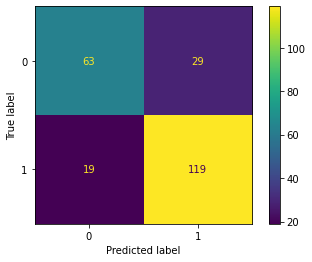

In [6]:
# Baseline model
clf = DecisionTreeClassifier(random_state=0).fit(X_train, y_train)

y_pred = clf.predict(X_test)

# Print accuracy
print(f'Train: {clf.score(X_train, y_train):.3f}')
print(f'Test: {clf.score(X_test, y_test):.3f}')
print(f'F1: {f1_score(y_test, y_pred):.3f}')

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)

disp.plot()
plt.show()

# Grid Search

Fitting 5 folds for each of 26400 candidates, totalling 132000 fits
Runtime:20.951929330825806
Best Score: 0.874
Best Parameters
{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 5, 'splitter': 'random'}
Validation Accuracy: 0.895
Test Accuracy: 0.875
F1 Score: 0.875


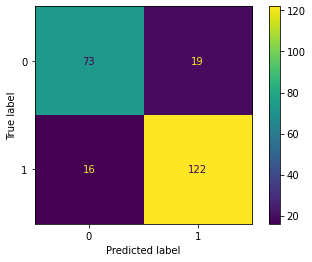

In [10]:
parameters = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'splitter': ['best', 'random'],
    'max_depth': [i for i in range(1, 21)],
    'ccp_alpha': [i/100000 for i in range(0, 51, 5)],
    'class_weight': [None, 'balanced'],
}

dt = DecisionTreeClassifier(random_state=0)

start_time = time.time()

clf = GridSearchCV(estimator=dt, 
                   param_grid=parameters, 
                   scoring='f1',
                   verbose=1,
                   n_jobs=-1).fit(X_train, y_train)

df = pd.DataFrame(clf.cv_results_)
df.tail()
df.to_csv('./results/hd/results_hd_dt.csv', index=False)

print(f'Runtime:{time.time() - start_time}')
print(f'Best Score: {clf.best_score_:.3f}')
print('Best Parameters')
print(clf.best_params_)

y_pred = clf.predict(X_test)

# Print accuracy
print(f'Validation Accuracy: {clf.score(X_train, y_train):.3f}')
print(f'Test Accuracy: {clf.score(X_test, y_test):.3f}')
print(f'F1 Score: {f1_score(y_test, y_pred):.3f}')

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)

disp.plot()
plt.show()

# Final Graphs

### Pre-Pruning: Max Depth

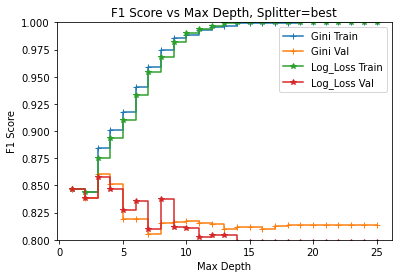

Best F1: 0.881
Best Depth: 7


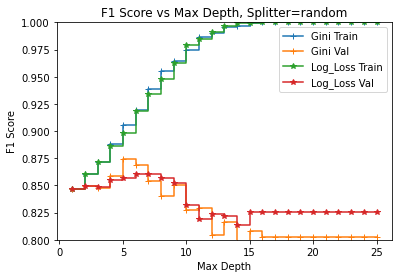

Best F1: 0.881
Best Depth: 7


In [54]:
# Max Depth
max_d = 26

# Splitter
splitters = ['best', 'random']

for splitter in splitters:
    train_gini = []
    test_gini = []
    train_log = []
    test_log = []

    for i in range(1, max_d):
        # Gini
        scores = cross_validate(estimator=DecisionTreeClassifier(criterion='gini',
                                                         splitter=splitter,
                                                         max_depth=i,
                                                         random_state=0),
                                X=X_train, 
                                y=y_train,
                                scoring='f1',
                                return_train_score=True,
                                return_estimator=True,
                                n_jobs=-1)

        # Append scores
        train_gini.append(scores['train_score'].mean())
        test_gini.append(scores['test_score'].mean())
        
        # Log_loss
        scores = cross_validate(estimator=DecisionTreeClassifier(criterion='log_loss',
                                                         splitter=splitter,
                                                         max_depth=i,
                                                         random_state=0),
                                X=X_train, 
                                y=y_train,
                                scoring='f1',
                                return_train_score=True,
                                return_estimator=True,
                                n_jobs=-1)

        # Append scores
        train_log.append(scores['train_score'].mean())
        test_log.append(scores['test_score'].mean())

    # Plot Scores
    fig, ax = plt.subplots()
    ax.set_xlabel('Max Depth')
    ax.set_ylabel('F1 Score')
    ax.set_title(f'F1 Score vs Max Depth, Splitter={splitter}')
    ax.set_ylim([0.8, 1.0])
    
    ax.plot(list(range(1,max_d)), train_gini, marker="+", label="Gini Train", drawstyle="steps-post")
    ax.plot(list(range(1,max_d)), test_gini, marker="+", label="Gini Val", drawstyle="steps-post")
    ax.plot(list(range(1,max_d)), train_log, marker="*", label="Log_Loss Train", drawstyle="steps-post")
    ax.plot(list(range(1,max_d)), test_log, marker="*", label="Log_Loss Val", drawstyle="steps-post")

    ax.legend()
    plt.show()

    best_depth = np.argmax(test_f1) + 1

    # Print best scores
    print(f'Best F1: {max(test_f1):.3f}')
    print(f'Best Depth: {best_depth}')

### Post-Pruning: Minimal Cost-Complexity

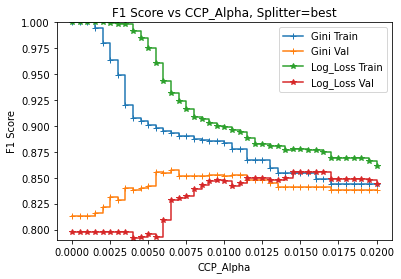

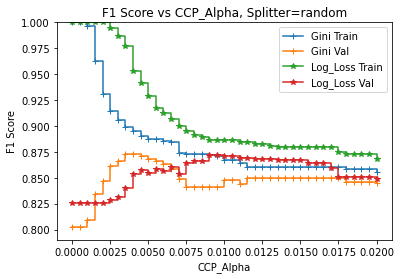

In [60]:
# Max Depth
ccp_alphas = [i/10000 for i in range(0, 201, 5)]

# Splitter
splitters = ['best', 'random']

for splitter in splitters:
    train_gini = []
    test_gini = []
    train_log = []
    test_log = []

    for ccp_alpha in ccp_alphas:
        # Gini
        scores = cross_validate(estimator=DecisionTreeClassifier(criterion='gini',
                                                         splitter=splitter,
                                                         ccp_alpha=ccp_alpha,
                                                         random_state=0),
                                X=X_train, 
                                y=y_train,
                                scoring='f1',
                                return_train_score=True,
                                return_estimator=True,
                                n_jobs=-1)

        # Append scores
        train_gini.append(scores['train_score'].mean())
        test_gini.append(scores['test_score'].mean())
        
        # Log_loss
        scores = cross_validate(estimator=DecisionTreeClassifier(criterion='log_loss',
                                                         splitter=splitter,
                                                         ccp_alpha=ccp_alpha,
                                                         random_state=0),
                                X=X_train, 
                                y=y_train,
                                scoring='f1',
                                return_train_score=True,
                                return_estimator=True,
                                n_jobs=-1)

        # Append scores
        train_log.append(scores['train_score'].mean())
        test_log.append(scores['test_score'].mean())

    # Plot Scores
    fig, ax = plt.subplots()
    ax.set_xlabel('CCP_Alpha')
    ax.set_ylabel('F1 Score')
    ax.set_title(f'F1 Score vs CCP_Alpha, Splitter={splitter}')
    ax.set_ylim([0.79, 1.0])
    
    ax.plot(ccp_alphas, train_gini, marker="+", label="Gini Train", drawstyle="steps-post")
    ax.plot(ccp_alphas, test_gini, marker="+", label="Gini Val", drawstyle="steps-post")
    ax.plot(ccp_alphas, train_log, marker="*", label="Log_Loss Train", drawstyle="steps-post")
    ax.plot(ccp_alphas, test_log, marker="*", label="Log_Loss Val", drawstyle="steps-post")

    ax.legend()
    plt.show()